# **TREC-COVID Query Analysis**

In this notebook I will be conducting query analysis in order to understand the types of queries made available in TREC-COVID.

## **Setup**

In [1]:
!pip install --upgrade python-terrier

     |████████████████████████████████| 97 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 13.2 MB/s 
     |████████████████████████████████| 69 kB 4.8 MB/s 
     |████████████████████████████████| 255 kB 52.5 MB/s 
     |████████████████████████████████| 41 kB 318 kB/s 
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 126 kB 73.4 MB/s 
     |████████████████████████████████| 294 kB 55.4 MB/s 
     |████████████████████████████████| 6.4 MB 40.0 MB/s 
     |████████████████████████████████| 1.2 MB 39.8 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
     |████████████████████████████████| 291 kB 47.6 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none-any.whl size=103883 sha256=0034c65a0c33ddf229feb5da2fc2323806e73f28461a12181de8e1424f8cc9f6
  Stored in directory: /root/.cac

In [2]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics('title')

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [9.25MB/s]
/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [5]:
topics = list(topics['query'])

In [6]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
     |████████████████████████████████| 6.5 MB 34.4 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the Tokenizer and Sequence Classification model from the HuggingFace repo
# Both are based on microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract with
# fine-tuning on the model for this topic/article type prediction task
tokenizer = AutoTokenizer.from_pretrained("jakelever/coronabert")
model = AutoModelForSequenceClassification.from_pretrained("jakelever/coronabert")

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/220k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [8]:
classifications = []

for topic in topics:

  text = [topic]
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=500)
  outputs = model(**inputs)
  scores = outputs.logits[0,:].tolist()
  from scipy.special import expit
  scores = expit(scores)
  scores = outputs.logits[0,:].tolist()
  from scipy.special import expit
  scores = expit(scores)
  scores_with_labels = [ (s,model.config.id2label[i]) for i,s in enumerate(scores) ]
  classifications.append(sorted(scores_with_labels, reverse=True))

In [9]:
top_classifications = []
for classification in classifications:
  top_classifications.append(classification[0][1])


In [10]:
x_labels = list(pd.DataFrame(top_classifications).value_counts().index)
y_values = list(pd.DataFrame(top_classifications).value_counts().values)
refined_x = []
for label in x_labels:
  refined_x.append(label[0])

## **Results**

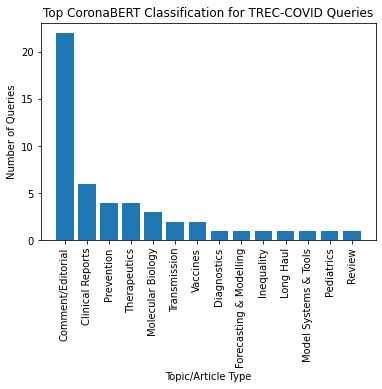

In [12]:
plt.bar(refined_x, y_values)
plt.xticks(rotation=90)
plt.title('Top CoronaBERT Classification for TREC-COVID Queries')
plt.xlabel('Topic/Article Type')
plt.ylabel('Number of Queries')
plt.savefig("trec_query_classification.pdf", format="pdf", bbox_inches="tight") 